
Creating feature importance visualizations...
Saved: feature_importance_bar.png


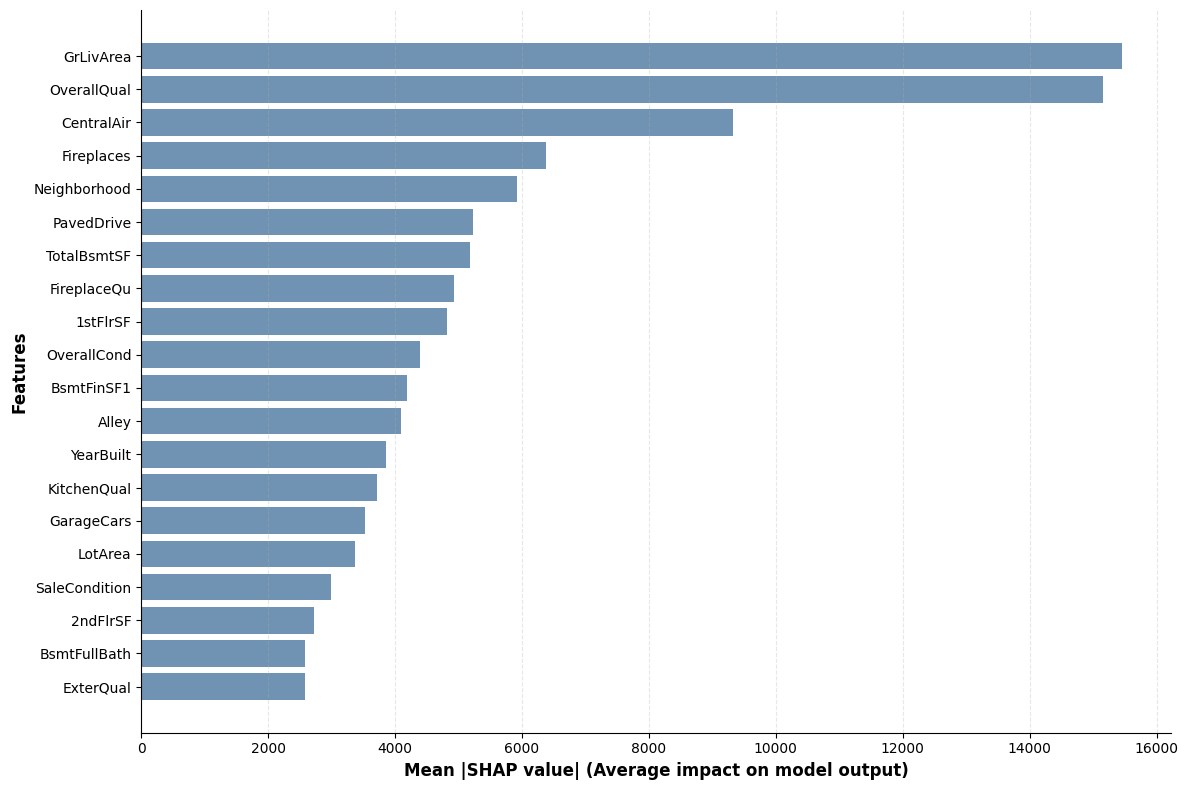

/tmp/ipykernel_4593/3161227427.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Saved: combined_feature_importance.png


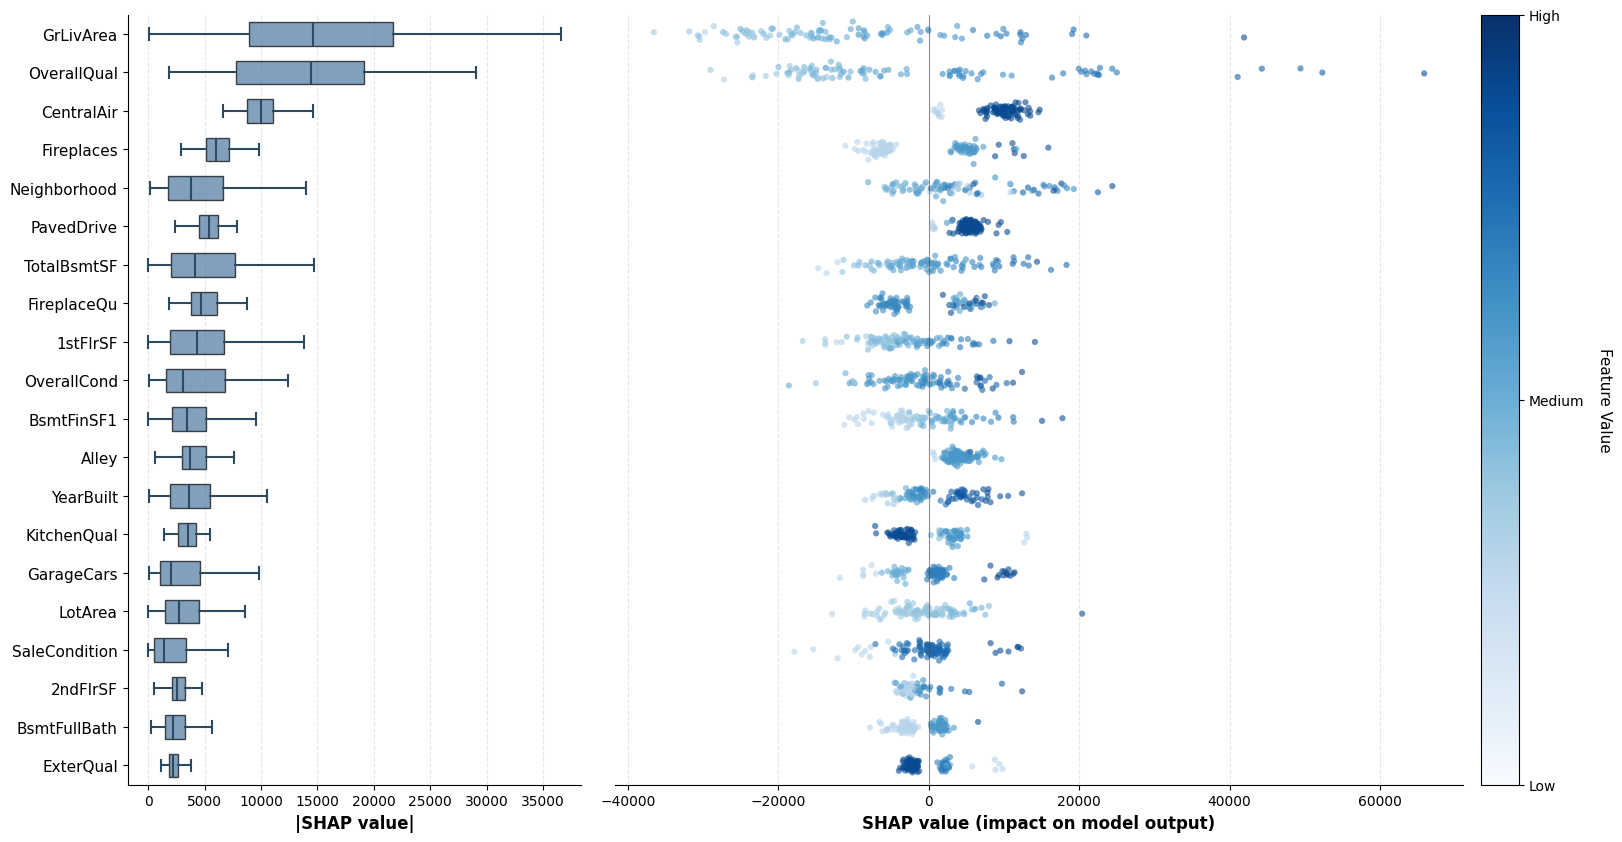


TOP 20 MOST IMPORTANT FEATURES
Rank   Feature Name                   Mean |SHAP|    
--------------------------------------------------------------------------------
1      GrLivArea                      15453.291159   
2      OverallQual                    15159.952559   
3      CentralAir                     9323.400254    
4      Fireplaces                     6377.481927    
5      Neighborhood                   5920.913893    
6      PavedDrive                     5231.377116    
7      TotalBsmtSF                    5183.979798    
8      FireplaceQu                    4931.274297    
9      1stFlrSF                       4825.444128    
10     OverallCond                    4392.883216    
11     BsmtFinSF1                     4190.206126    
12     Alley                          4096.363353    
13     YearBuilt                      3864.054212    
14     KitchenQual                    3711.751680    
15     GarageCars                     3532.287975    
16     LotArea         

In [4]:
# --- 6. Create Feature Importance Visualizations ---
print("\nCreating feature importance visualizations...")

# Define the color scheme
BLUE_COLOR = '#4C78A0'

# Calculate mean absolute SHAP value for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Create DataFrame for easier plotting
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=True)

# Get top 20 features
top_n = 20
top_features = feature_importance_df.tail(top_n)
top_feature_indices = feature_importance_df.tail(top_n).index.tolist()

# 6.1 Bar plot of mean absolute SHAP values (Feature Importance)
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar plot
bars = ax.barh(range(len(top_features)), top_features['importance'], color=BLUE_COLOR, alpha=0.8)

# Customize plot
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Mean |SHAP value| (Average impact on model output)', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('feature_importance_bar.png', dpi=300, bbox_inches='tight')
print("Saved: feature_importance_bar.png")
plt.show()

# 6.2 Combined Figure: Box Plot (left) + SHAP Summary Plot (right)
fig = plt.figure(figsize=(18, 10))

# Create grid spec with width ratio 1:2 (box plot smaller, SHAP plot larger)
gs = fig.add_gridspec(1, 2, width_ratios=[1, 2], wspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# --- LEFT PANEL: Box Plot ---
positions = range(len(top_features))
bp = ax1.boxplot([np.abs(shap_values.values[:, feature_importance_df.tail(top_n).index[i]]) 
                   for i in range(len(top_features))],
                  positions=positions,
                  vert=False,
                  widths=0.6,
                  patch_artist=True,
                  showfliers=False)

# Customize box plot colors
for patch in bp['boxes']:
    patch.set_facecolor(BLUE_COLOR)
    patch.set_alpha(0.7)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='#2C4A60', linewidth=1.5)

ax1.set_yticks(positions)
ax1.set_yticklabels(top_features['feature'], fontsize=11)
ax1.set_xlabel('|SHAP value|', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# --- RIGHT PANEL: SHAP Summary Plot ---
# Plot each feature - use same order as box plot (not reversed)
for idx, feature_idx in enumerate(top_feature_indices):
    feature_name = feature_names[feature_idx]
    shap_vals = shap_values.values[:, feature_idx]
    feature_vals = X_explain.iloc[:, feature_idx].values
    
    # Normalize feature values for color mapping
    if feature_vals.max() - feature_vals.min() > 0:
        norm_vals = (feature_vals - feature_vals.min()) / (feature_vals.max() - feature_vals.min())
    else:
        norm_vals = np.ones_like(feature_vals) * 0.5
    
    # Create color map from light blue to dark blue
    colors = plt.cm.Blues(0.3 + 0.6 * norm_vals)
    
    # Plot points with jitter
    y_pos = np.ones_like(shap_vals) * idx + np.random.randn(len(shap_vals)) * 0.1
    scatter = ax2.scatter(shap_vals, y_pos, c=colors, alpha=0.6, s=20, edgecolors='none')

# Remove y-axis labels and ticks from right panel
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.set_ylim(ax1.get_ylim())  # Ensure same y-axis range as left panel
ax2.set_xlabel('SHAP value (impact on model output)', fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='#333333', linestyle='-', linewidth=0.8, alpha=0.5)
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, pad=0.02, fraction=0.046)
cbar.set_label('Feature Value', fontsize=11, rotation=270, labelpad=20)
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Low', 'Medium', 'High'])

plt.tight_layout()
plt.savefig('combined_feature_importance.png', dpi=300, bbox_inches='tight')
print("\nSaved: combined_feature_importance.png")
plt.show()

# 6.3 Detailed Feature Importance Table
print("\n" + "="*80)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*80)
print(f"{'Rank':<6} {'Feature Name':<30} {'Mean |SHAP|':<15}")
print("-"*80)
for rank, (idx, row) in enumerate(feature_importance_df.tail(20).iloc[::-1].iterrows(), 1):
    print(f"{rank:<6} {row['feature']:<30} {row['importance']:<15.6f}")
print("="*80)

print("\n" + "="*80)
print("Feature importance visualization completed successfully!")
print("Generated files:")
print("  1. feature_importance_bar.png - Bar chart of top features")
print("  2. combined_feature_importance.png - Box plot + SHAP summary plot (combined)")
print("="*80)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabpfn import TabPFNRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import os

print("--- TabPFN Feature Importance & SHAP Visualization ---")

# --- 1. Define file paths ---
base_path: str = "data/"
train_file_path = os.path.join(base_path, 'train.csv')
test_file_path = os.path.join(base_path, 'test.csv')

# --- 2. Load data ---
try:
    train_df = pd.read_csv(train_file_path)
    test_df = pd.read_csv(test_file_path)
    print(f"✅ Loaded training data (shape: {train_df.shape}) and test data (shape: {test_df.shape}).")
except FileNotFoundError as e:
    print(f"❌ Error: File not found. Please check path: {e.filename}")
    exit()

# --- 3. Data preprocessing ---
print("\n⚙️ Starting data preparation and preprocessing...")

test_ids = test_df['Id']
y_train = train_df['SalePrice']

train_features = train_df.drop(columns=['Id', 'SalePrice'])
test_features = test_df.drop(columns=['Id'])

# ✅ Add Neighborhood mapping
neighborhood_map = {
    'IDOTRR': 1, 'MeadowV': 1, 'BrDale': 1,
    'BrkSide': 2, 'OldTown': 2,
    'Edwards': 3, 'NPkVill': 3, 'Blueste': 3,
    'Sawyer': 4, 'SWISU': 4, 'Mitchel': 4,
    'Names': 5, 'ClearCr': 5,
    'NWAmes': 6, 'Blmngtn': 6,
    'CollgCr': 7, 'SawyerW': 7, 'Gilbert': 7,
    'Crawfor': 8, 'Somerst': 8,
    'Timber': 9, 'Veenker': 9,
    'NoRidge': 10, 'NridgHt': 10, 'StoneBr': 10
}
for df in [train_features, test_features]:
    if 'Neighborhood' in df.columns:
        df['Neighborhood_Score'] = df['Neighborhood'].map(neighborhood_map).fillna(5)
        df.drop(columns=['Neighborhood'], inplace=True)

n_train = len(train_features)
combined_features = pd.concat([train_features, test_features], ignore_index=True)

numerical_features = combined_features.select_dtypes(include=np.number).columns.tolist()
categorical_features = combined_features.select_dtypes(exclude=np.number).columns.tolist()

print(f"Found {len(numerical_features)} numerical features and {len(categorical_features)} categorical features.")

# Impute and encode
imputer_numerical = SimpleImputer(strategy='median')
combined_features[numerical_features] = imputer_numerical.fit_transform(combined_features[numerical_features])

for col in categorical_features:
    combined_features[col] = combined_features[col].fillna('Missing')
    le = LabelEncoder()
    combined_features[col] = le.fit_transform(combined_features[col])

# Split back
X_train_processed = combined_features.iloc[:n_train]
X_test_processed = combined_features.iloc[n_train:]

feature_names = X_train_processed.columns.tolist()
print(f"✅ Training set shape: {X_train_processed.shape}")

# --- 4. Train TabPFN model ---
print("\n🚀 Training TabPFN model...")
regressor = TabPFNRegressor()
regressor.fit(X_train_processed, y_train)
print("✅ Model training completed.")

# --- 5. Compute SHAP values ---
print("\n⚡ Computing SHAP values...")
try:
    import shap

    X_explain = X_train_processed.iloc[:100]
    explainer = shap.Explainer(regressor.predict, np.ones(X_train_processed.iloc[0:1, :].shape) * float("nan"))
    shap_values = explainer(X_explain)
    print(f"✅ SHAP values computed successfully. Shape: {shap_values.values.shape}")

    # --- 6. SHAP Dependence Plots ---
    DEEP_BLUE = '#2C4A60'
    GRAY = '#333333'
    cmap = plt.cm.Blues
    plt.style.use('seaborn-v0_8-whitegrid')

    print("\n📊 Generating SHAP Dependence Plots with new color scheme...")

    plt.figure(figsize=(10, 6))
    shap.dependence_plot("GrLivArea", shap_values.values, X_explain,
                         interaction_index="OverallQual", cmap=cmap,
                         alpha=0.8, dot_size=40, show=False)
    plt.title("SHAP Dependence Plot: GrLivArea vs OverallQual", fontsize=14, fontweight='bold', color=DEEP_BLUE)
    plt.xlabel("GrLivArea (Feature Value)", fontsize=11, fontweight='bold', color=GRAY)
    plt.ylabel("SHAP Value", fontsize=11, fontweight='bold', color=GRAY)
    plt.grid(alpha=0.3, linestyle='--', color=GRAY)
    plt.tight_layout()
    plt.savefig("shap_dependence_GrLivArea_vs_OverallQual.png", dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 6))
    shap.dependence_plot("OverallQual", shap_values.values, X_explain,
                         interaction_index="Neighborhood_Score", cmap=cmap,
                         alpha=0.8, dot_size=40, show=False)
    plt.title("SHAP Dependence Plot: OverallQual vs Neighborhood_Score", fontsize=14, fontweight='bold', color=DEEP_BLUE)
    plt.xlabel("OverallQual (Feature Value)", fontsize=11, fontweight='bold', color=GRAY)
    plt.ylabel("SHAP Value", fontsize=11, fontweight='bold', color=GRAY)
    plt.grid(alpha=0.3, linestyle='--', color=GRAY)
    plt.tight_layout()
    plt.savefig("shap_dependence_OverallQual_vs_NeighborhoodScore.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Dependence plots generated successfully.\n")

    # --- 7. Feature Importance Visualizations ---
    print("📈 Creating feature importance visualizations...")

    BLUE_COLOR = '#4C78A0'

    # Calculate mean |SHAP|
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': mean_abs_shap
    }).sort_values('importance', ascending=True)

    top_n = 20
    top_features = feature_importance_df.tail(top_n)
    top_feature_indices = feature_importance_df.tail(top_n).index.tolist()

    # --- 7.1 Bar Chart ---
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(range(len(top_features)), top_features['importance'], color=BLUE_COLOR, alpha=0.8)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Mean |SHAP value| (Average impact on model output)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Features', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--', color=GRAY)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig('feature_importance_bar.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: feature_importance_bar.png")
    plt.show()

    # --- 7.2 Combined Box + Summary Plot ---
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 2], wspace=0.05)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    positions = range(len(top_features))
    bp = ax1.boxplot([np.abs(shap_values.values[:, feature_importance_df.tail(top_n).index[i]])
                      for i in range(len(top_features))],
                     positions=positions, vert=False, widths=0.6, patch_artist=True, showfliers=False)
    for patch in bp['boxes']:
        patch.set_facecolor(BLUE_COLOR)
        patch.set_alpha(0.7)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#2C4A60', linewidth=1.5)

    ax1.set_yticks(positions)
    ax1.set_yticklabels(top_features['feature'], fontsize=11)
    ax1.set_xlabel('|SHAP value|', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3, linestyle='--', color=GRAY)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for idx, feature_idx in enumerate(top_feature_indices):
        shap_vals = shap_values.values[:, feature_idx]
        feature_vals = X_explain.iloc[:, feature_idx].values
        norm_vals = (feature_vals - feature_vals.min()) / (feature_vals.max() - feature_vals.min()) if feature_vals.max() != feature_vals.min() else np.ones_like(feature_vals)*0.5
        colors = plt.cm.Blues(0.3 + 0.6 * norm_vals)
        y_pos = np.ones_like(shap_vals) * idx + np.random.randn(len(shap_vals)) * 0.1
        ax2.scatter(shap_vals, y_pos, c=colors, alpha=0.6, s=20, edgecolors='none')

    ax2.set_yticks([])
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlabel('SHAP value (impact on model output)', fontsize=12, fontweight='bold')
    ax2.axvline(x=0, color=GRAY, linestyle='-', linewidth=0.8, alpha=0.5)
    ax2.grid(axis='x', alpha=0.3, linestyle='--', color=GRAY)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(left=False)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax2, pad=0.02, fraction=0.046)
    cbar.set_label('Feature Value', fontsize=11, rotation=270, labelpad=20)
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['Low', 'Medium', 'High'])

    plt.tight_layout()
    plt.savefig('combined_feature_importance.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: combined_feature_importance.png")
    plt.show()

    print("\n" + "="*80)
    print("TOP 20 MOST IMPORTANT FEATURES")
    print("="*80)
    print(f"{'Rank':<6} {'Feature Name':<30} {'Mean |SHAP|':<15}")
    print("-"*80)
    for rank, (idx, row) in enumerate(feature_importance_df.tail(20).iloc[::-1].iterrows(), 1):
        print(f"{rank:<6} {row['feature']:<30} {row['importance']:<15.6f}")
    print("="*80)

    print("\n✅ Feature importance visualization completed successfully!")
    print("Generated files:")
    print("  1. shap_dependence_GrLivArea_vs_OverallQual.png")
    print("  2. shap_dependence_OverallQual_vs_NeighborhoodScore.png")
    print("  3. feature_importance_bar.png")
    print("  4. combined_feature_importance.png")
    print("="*80)

except ImportError:
    print("❌ Error: 'shap' package is required. Install it with: pip install shap")
    exit()